In [ ]:
!pip install mdtraj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mdtraj: filename=mdtraj-1.9.7-cp38-cp38-linux_x86_64.whl size=8467786 sha256=0dce032a7994125d5e0e841dfdaa45c7798493e811dd4820020b30559a0dc8e9
  Stored in directory: /root/.cache/pip/wheels/68/ff/96/5d9a2efac5e5918e5c8fd799e8703e2f8b804a029bcbbd2431
Successfully built mdtraj


In [ ]:
import mdtraj as md
import numpy as np
import scipy.cluster.hierarchy
import matplotlib.pyplot as plt

# Load the trajectory file
traj = md.load('1D5R_wb_prod.dcd', top='1D5R_wb_ionized.psf')

# Select the protein atoms
protein_sel = traj.topology.select('protein')
protein_traj = traj.atom_slice(protein_sel)

# Select the CA atoms
protein_CA_sel = protein_traj.topology.select('name CA')

# Calculate RMSD
rmsd1 = md.rmsd(protein_traj, protein_traj, 0, atom_indices= protein_CA_sel)
print(rmsd1)

[0.         0.04706012 0.05373321 ... 0.26059023 0.25796658 0.2596972 ]


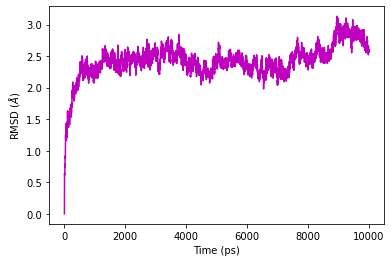

In [22]:
plt.plot(np.arange(0, len(rmsd1)), rmsd1*10, color='m')
## what does np.arange do?
plt.xlabel('Time (ps)')
plt.ylabel('RMSD ($\AA$)')
plt.draw()

In [26]:
# Calculate pairwise RMSD
protein_sel = traj.topology.select('protein and backbone')
protein_traj = traj.atom_slice(protein_sel)

distances = np.empty((protein_traj.n_frames, protein_traj.n_frames))
for i in range(protein_traj.n_frames):
    distances[i] = md.rmsd(protein_traj, protein_traj, i)
print('Max pairwise rmsd: %f nm' % np.max(distances))

Max pairwise rmsd: 0.335533 nm


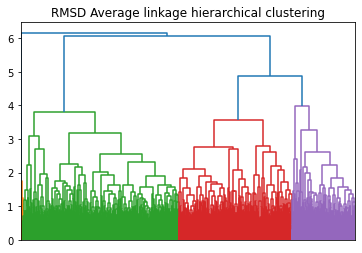

In [27]:
# Perform hierarchical clustering
linkage = scipy.cluster.hierarchy.linkage(distances, method='average')

# Plot the dendrogram
plt.title('RMSD Average linkage hierarchical clustering')
scipy.cluster.hierarchy.dendrogram(linkage, no_labels=True, count_sort='descendent')
plt.show()

Finding the structure within the cluster with the lowest average RMSD, which has the closest RMSD to the average RMSD of that cluster

In [50]:
cutoff = 5.00 # The maximum distance between merged clusters
clusters = scipy.cluster.hierarchy.fcluster(linkage, cutoff, criterion='distance')

# Create a dictionary to store the RMSD of each frame from frame 0 for each cluster
average_rmsd = {i: distances[clusters == i, 0] for i in set(clusters)}
    
# Iterate over each cluster and calculate the average RMSD
for i in average_rmsd:
    print('Cluster %d: Average RMSD = %f nm' % (i, np.mean(average_rmsd[i])))

Cluster 1: Average RMSD = 0.102349 nm
Cluster 2: Average RMSD = 0.234923 nm
Cluster 3: Average RMSD = 0.246878 nm


In [51]:
# Get the cluster number with the smallest RMSD
cluster_num = min(average_rmsd, key=lambda x: np.mean(average_rmsd[x]))

# Get the RMSD values of the frames in that cluster
rmsd_values = average_rmsd[cluster_num][1:]

#Get the average RMSD of the cluster
average_rmsd_cluster = np.mean(rmsd_values)

#Get the index of the frame with the closest RMSD to the average RMSD of the cluster
min_rmsd_index = np.argmin(np.abs(rmsd_values - average_rmsd_cluster))

#Get the index of the frame in the original trajectory
frame_index = np.where(clusters == cluster_num)[0][min_rmsd_index]
print("The index of the frame in the original trajectory closest to the average RMSD of cluster %d is: %d" % (cluster_num, frame_index))

The index of the frame in the original trajectory closest to the average RMSD of cluster 1 is: 32


Finding the centroid of the cluster with the lowest RMSD

In [54]:
# Define the temperature parameter beta
beta = 1

# Calculate the weight of each frame
weights = np.exp(-beta*distances / distances.std())

# Get the index of the representative structure
index = weights[clusters == cluster_num].sum(axis=1).argmax()

# Print the index of the representative structure
print("The index of the representative structure frame of cluster %d is: %d" % (cluster_num, index))

The index of the representative structure frame of cluster 1 is: 70


In [55]:
centroid = traj[index]
print(centroid)

<mdtraj.Trajectory with 1 frames, 29452 atoms, 8275 residues, and unitcells>
